In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from itertools import repeat
from multiprocessing import Pool
from sys import path
from time import time

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.typing import NDArray
from reservoirpy.model import Model
from reservoirpy.nodes import ESN, Input, Reservoir, Ridge  # type
from sklearn.preprocessing import RobustScaler

# it has change do not delete benchmark_1,2 and 3!
# it now should be faster because float32
from utils.data import get_dataframe, prepare_data

# Data

In [2]:
SERIES_COLUMN_NAME = "individus"
TIMESTEPS_COLUMN_NAME = "temps"
X_LABELS = ["x2_x5", "x4_x7"]
Y_LABELS = ["y_fixed_obs"]

In [3]:
file_01 = "../../data/synthetic_bph_1/simulation1.csv"


# train_data = Data(
#     file_01,
#     SERIES_COLUMN_NAME,
#     TIMESTEPS_COLUMN_NAME,
#     X_LABELS,
#     Y_LABELS,
# )

# train_data.apply_fit_transform(RobustScaler(), RobustScaler())

# Benchmark

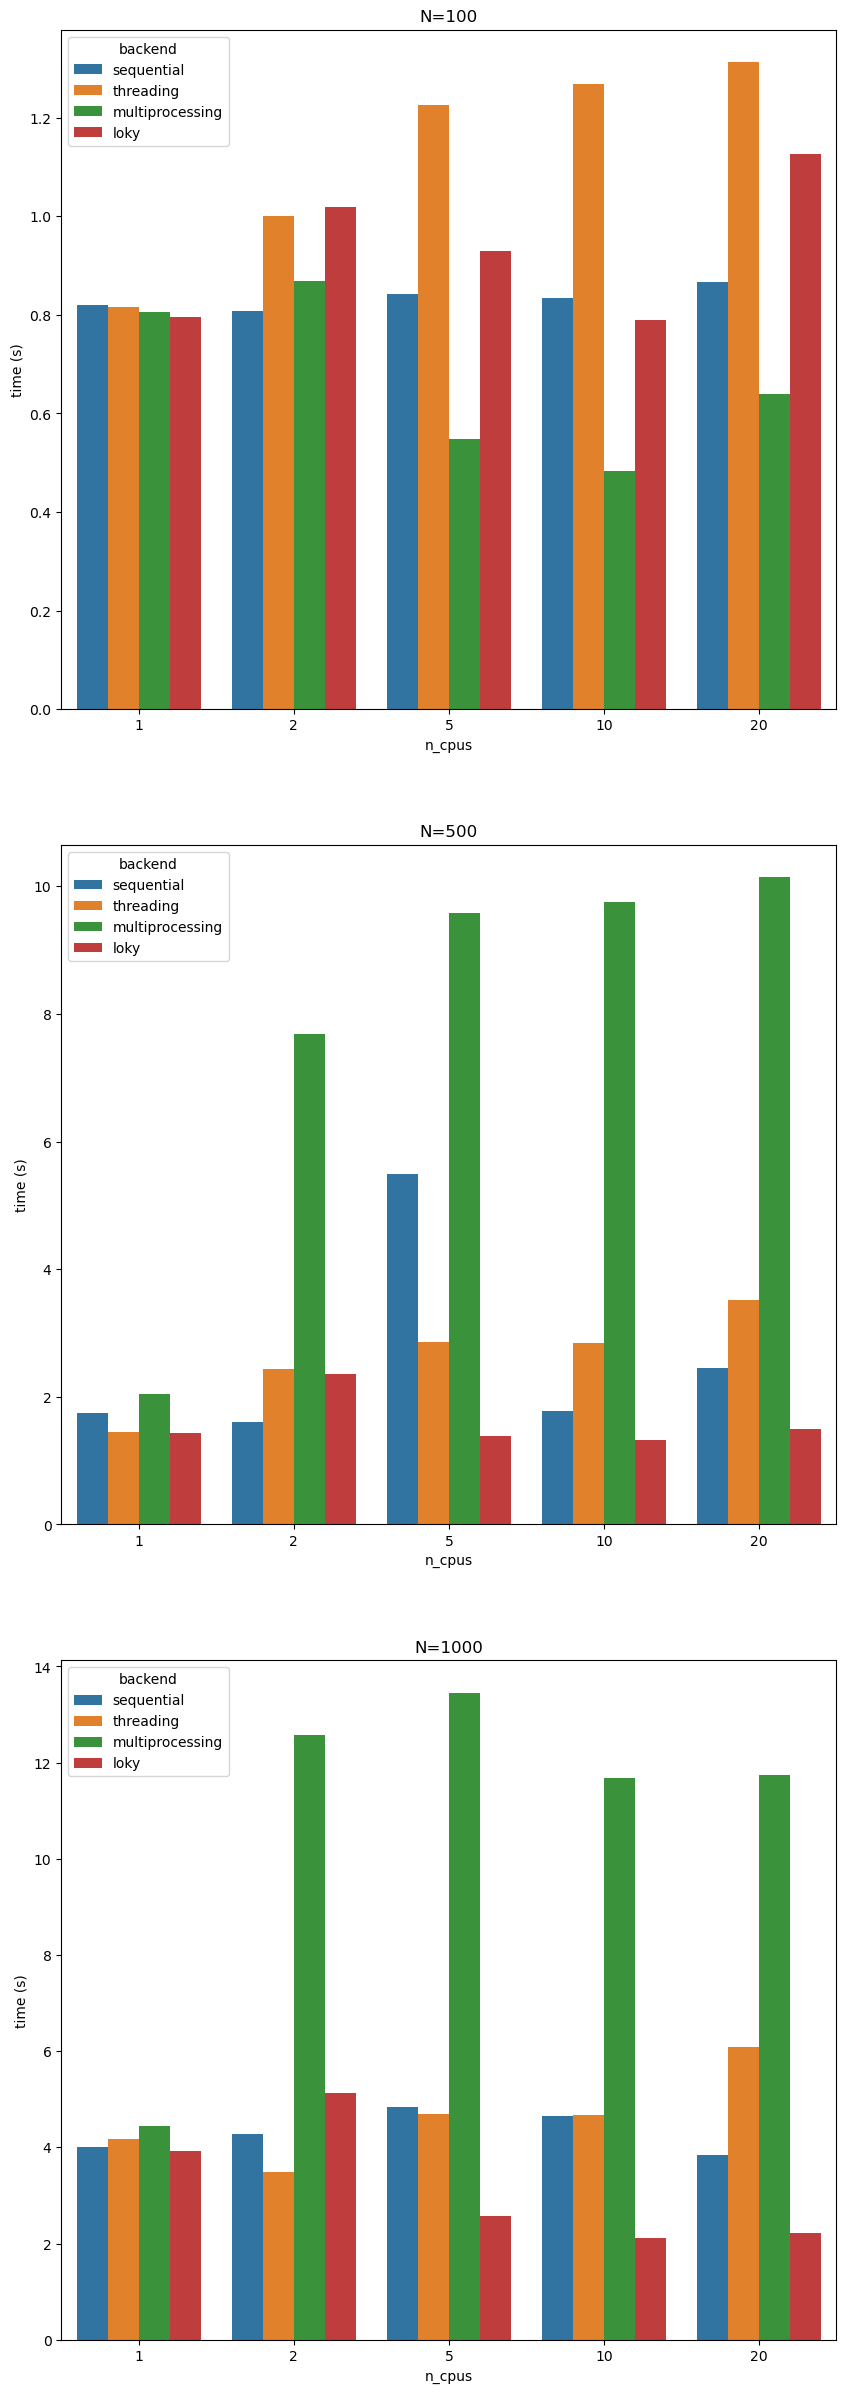

In [4]:
csv = "benchmark_1.csv"

try:
    df = pd.read_csv(csv)
except:
    df_list = []
    for units in [100, 500, 1000]:
        for n_cpus in [1, 2, 5, 10, 20]:
            for backend in ["sequential", "threading", "multiprocessing", "loky"]:
                reservoir = Reservoir(
                    units=units,
                    sr=0.1,
                    lr=0.1,
                    seed=0,
                )
                readout = Ridge(
                    ridge=0.1,
                )
                model = ESN(
                    reservoir=reservoir,
                    readout=readout,
                    workers=n_cpus,
                    backend=backend,
                    use_raw_inputs=False,
                    feedback=False,
                )

                t0 = time()
                model.fit(X=train_data.x_3D_scaled, Y=train_data.y_3D_scaled)
                df_list.append(
                    {
                        "units": units,
                        "n_cpus": n_cpus,
                        "backend": backend,
                        "time (s)": time() - t0,
                    }
                )

    df = pd.DataFrame(df_list)
    df.to_csv(csv)


units_list = df["units"].unique()
n_plots = len(units_list)

_, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(10, 10 * n_plots))


for i, units in enumerate(units_list):
    df_plot = df[df["units"] == units]
    sns.barplot(df_plot, x="n_cpus", y="time (s)", hue="backend", ax=axs[i])
    axs[i].set_title(f"N={units}")

The various distributions of execution… are improductive for small neurons numbers, and "loky" is barely productive for high neurons numbers.

# Trying multiprocessing on a list of models (different seeds)

## 

```python
if chunksize is None:
        chunksize, extra = divmod(len(iterable), len(self._pool) * 4)
        if extra:
            chunksize += 1
```

In [5]:
n_seeds = 5
for n_cpus in range(1, 5):
    chunksize, extra = divmod(n_seeds, n_cpus * 4)
    if extra:
        chunksize += 1
    print(f"n_cpus: {n_cpus}\tchunksize:{chunksize}")

n_cpus: 1	chunksize:2
n_cpus: 2	chunksize:1
n_cpus: 3	chunksize:1
n_cpus: 4	chunksize:1


## Passing the model

**Note**

We cannot use ESN from reservoirpy as it automatically renames the instance of ESN, Reservoir and Ridge:

```python
'ESN-271': ESN('Reservoir-206', 'Ridge-206')
# becomes
'ESN-271-(copy)': ESN('Reservoir-206-(copy)', 'Ridge-206-(copy)')
# and the we get
KeyError: 'Ridge-206'
```

In [6]:
class ModelConfiguration:
    """Helper to generate various Reservoir model configurations.

    Please see: https://reservoirpy.readthedocs.io/en/latest/user_guide/advanced_demo.html
    (quotes in comments/docstrings will refer to this pages)
    """

    def __init__(
        self,
        input_kwargs: dict,
        reservoir_kwargs: dict,
        ridge_kwargs: dict,
        fit_kwargs: dict,
        *,
        input_to_readout: bool,
        readout_feedback_to_reservoir: bool,
    ):
        assert isinstance(input_to_readout, bool)
        assert isinstance(readout_feedback_to_reservoir, bool)

        self.input_to_readout = input_to_readout
        self.readout_feedback_to_reservoir = readout_feedback_to_reservoir
        self.fit_kwargs = fit_kwargs
        #
        self.data = Input(**input_kwargs)
        self.reservoir = Reservoir(**reservoir_kwargs)
        self.readout = Ridge(**ridge_kwargs)
        self.model = self._get_model()
        print(self)

    def __str__(self):
        return self.reservoir.name + ":" + self.readout.name

    def __repr__(self):
        return self.reservoir.name + ":" + self.readout.name

    def set_reservoir_seed(self):
        self.reservoir.se

    def _get_model(self) -> Model:
        if self.readout_feedback_to_reservoir:
            self._set_readout_feedback()

        if self.input_to_readout:
            return self._get_input_in_readout_model()

        return self._get_simple_model()

    def _get_simple_model(self) -> Model:
        return self.data >> self.reservoir >> self.readout

    def _get_input_in_readout_model(self) -> Model:
        # https://reservoirpy.readthedocs.io/en/latest/user_guide/advanced_demo.html#Input-to-readout-connections
        return [self.data, self.data >> self.reservoir] >> self.readout

    def _set_readout_feedback(self) -> None:
        # https://reservoirpy.readthedocs.io/en/latest/user_guide/advanced_demo.html#Feedback-connections
        self.reservoir <<= self.readout

    def fit(self, X_train: NDArray, Y_train: NDArray) -> None:
        assert "force_teachers" not in self.fit_kwargs
        self.model.fit(
            X=X_train,
            Y=Y_train,
            # force_teacher is set to True by default,
            # and setting it to False makes the fit method "crash"
            #   (yeah sorry it is not more accurate so far)
            # force_teachers=self.readout_feedback,
            **self.fit_kwargs,
        )

    def run(self, X: NDArray) -> list[NDArray]:
        return self.model.run(X)

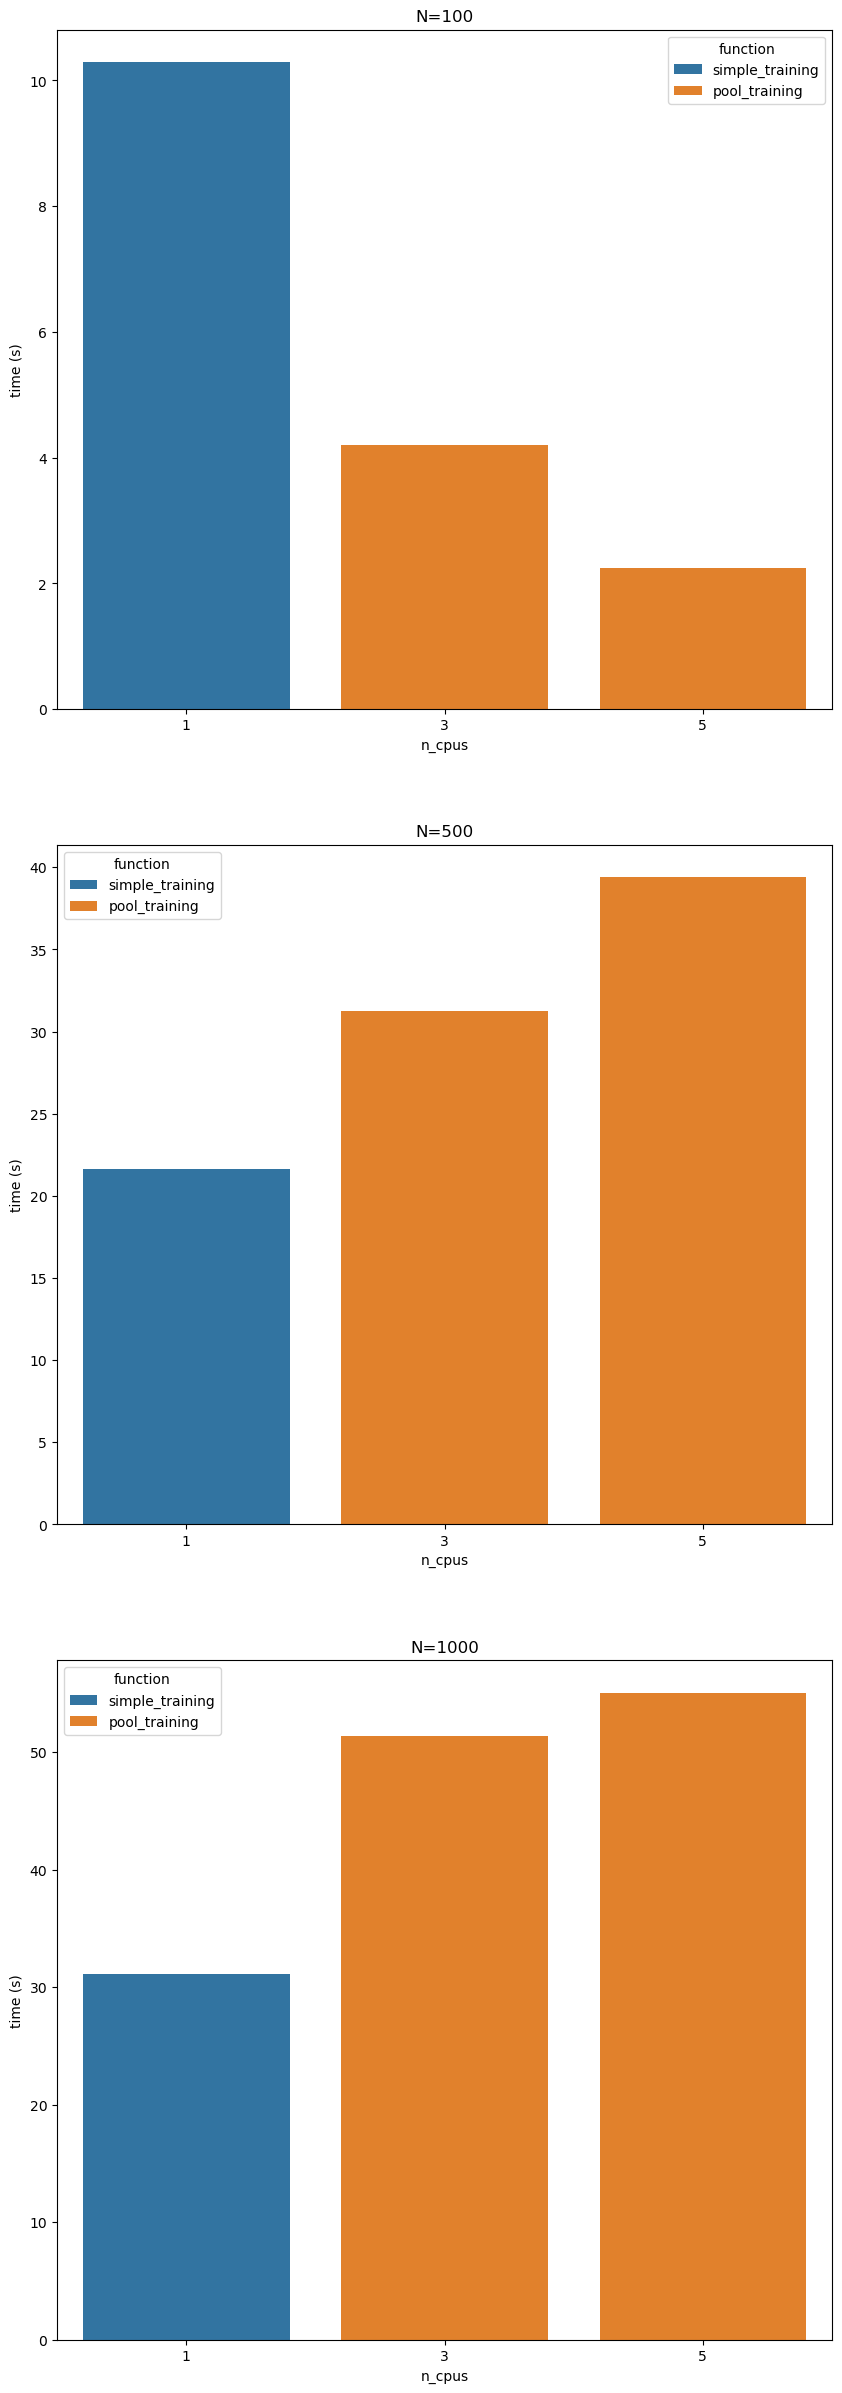

In [7]:
csv = "benchmark_2.csv"


def _training(model, train_data):
    model.fit(train_data.x_3D_scaled, train_data.y_3D_scaled)
    return model.run(train_data.x_3D_scaled)


def simple_training(model_list, train_data):
    trained_models = [_training(model, train_data) for model in model_list]


def pool_training(model_list, train_data, n_cpus: int, chunksize=None):
    with Pool(n_cpus) as p:
        trained_models = p.starmap(
            _training, zip(model_list, repeat(train_data)), chunksize=chunksize
        )


try:
    df = pd.read_csv(csv)
except:
    df_list = []
    for units in [100, 500, 1000]:
        ####
        list_models = []
        for seed in range(5):
            reservoir_dict = dict(
                units=units,
                sr=0.1,
                lr=0.1,
                seed=seed,
            )
            ridge_dict = dict(
                ridge=0.1,
            )

            model = ModelConfiguration(
                input_kwargs={},
                reservoir_kwargs=reservoir_dict,
                ridge_kwargs=ridge_dict,
                fit_kwargs={},
                input_to_readout=False,
                readout_feedback_to_reservoir=False,
            )
            list_models.append(model)
        ####
        for n_cpus in [3, 5]:

            t0 = time()
            pool_training(list_models, train_data, n_cpus)
            df_list.append(
                {
                    "units": units,
                    "n_cpus": n_cpus,
                    "function": "pool_training",
                    "time (s)": time() - t0,
                }
            )
        ######
        n_cpus = 1

        t0 = time()
        simple_training(list_models, train_data)
        df_list.append(
            {
                "units": units,
                "n_cpus": n_cpus,
                "function": "simple_training",
                "time (s)": time() - t0,
            }
        )

    df = pd.DataFrame(df_list)
    df.to_csv(csv)


units_list = df["units"].unique()
n_plots = len(units_list)

_, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(10, 10 * n_plots))


for i, units in enumerate(units_list):
    df_plot = df[df["units"] == units]
    sns.barplot(df_plot, x="n_cpus", y="time (s)", hue="function", ax=axs[i])
    axs[i].set_title(f"N={units}")

## Passing the parameters

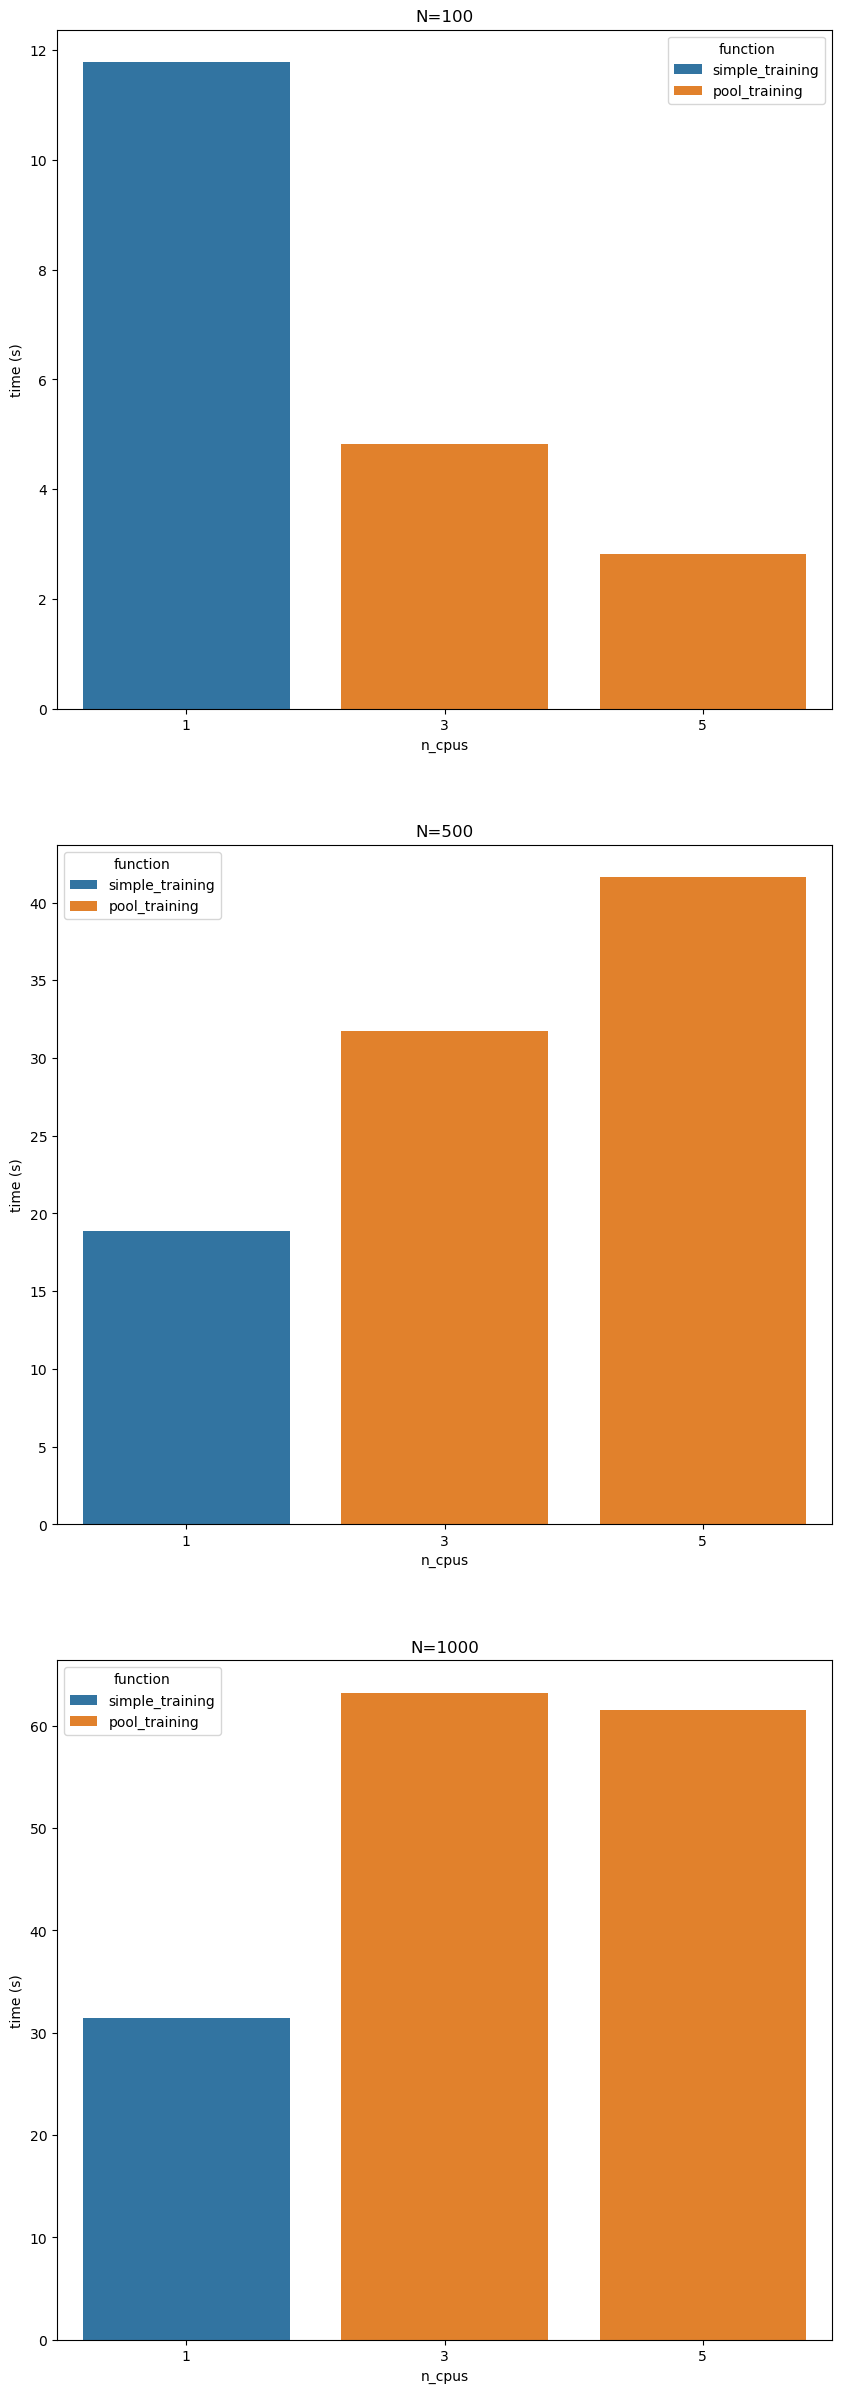

In [8]:
csv = "benchmark_3.csv"


def _training(params_tuple, train_data):
    reservoir_dict, ridge_dict = params_tuple
    model = ModelConfiguration(
        input_kwargs={},
        reservoir_kwargs=reservoir_dict,
        ridge_kwargs=ridge_dict,
        fit_kwargs={},
        input_to_readout=False,
        readout_feedback_to_reservoir=False,
    )
    model.fit(train_data.x_3D_scaled, train_data.y_3D_scaled)
    return model.run(train_data.x_3D_scaled)


def simple_training(params_tuple_list, train_data):
    preds_list = [
        _training(params_tuple, train_data) for params_tuple in params_tuple_list
    ]


def pool_training(params_tuple_list, train_data, n_cpus: int, chunksize=None):
    with Pool(n_cpus) as p:
        preds_list = p.starmap(
            _training, zip(params_tuple_list, repeat(train_data)), chunksize=chunksize
        )


try:
    df = pd.read_csv(csv)
except:
    df_list = []
    for units in [100, 500, 1000]:
        ####
        params_tuple_list = []
        for seed in range(5):
            reservoir_dict = dict(
                units=units,
                sr=0.1,
                lr=0.1,
                seed=seed,
            )
            ridge_dict = dict(
                ridge=0.1,
            )

            params_tuple_list.append((reservoir_dict, ridge_dict))
        ####
        for n_cpus in [3, 5]:
            t0 = time()
            pool_training(params_tuple_list, train_data, n_cpus)
            df_list.append(
                {
                    "units": units,
                    "n_cpus": n_cpus,
                    "function": "pool_training",
                    "time (s)": time() - t0,
                }
            )
        ######
        n_cpus = 1

        t0 = time()
        simple_training(params_tuple_list, train_data)
        df_list.append(
            {
                "units": units,
                "n_cpus": n_cpus,
                "function": "simple_training",
                "time (s)": time() - t0,
            }
        )

    df = pd.DataFrame(df_list)
    df.to_csv(csv)


units_list = df["units"].unique()
n_plots = len(units_list)

_, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(10, 10 * n_plots))


for i, units in enumerate(units_list):
    df_plot = df[df["units"] == units]
    sns.barplot(df_plot, x="n_cpus", y="time (s)", hue="function", ax=axs[i])
    axs[i].set_title(f"N={units}")

### Using shared memory

In [9]:
df = get_dataframe(file_01)


(
    x_train_3D_scaled,
    y_train_3D_scaled,
    _,
    _,
    _,
) = prepare_data(
    df_train=df,
    df_test=df,
    serie_column_name=SERIES_COLUMN_NAME,
    tstep_column_name=TIMESTEPS_COLUMN_NAME,
    x_labels=X_LABELS,
    y_labels=Y_LABELS,
    x_scaler=RobustScaler(),
    y_scaler=RobustScaler(),
)

Reservoir-0:Ridge-0Reservoir-0:Ridge-0Reservoir-0:Ridge-0


Reservoir-1:Ridge-1
Reservoir-1:Ridge-1
Reservoir-0:Ridge-0Reservoir-0:Ridge-0Reservoir-0:Ridge-0Reservoir-0:Ridge-0



Reservoir-0:Ridge-0
Reservoir-0:Ridge-0
Reservoir-1:Ridge-1
Reservoir-2:Ridge-2
Reservoir-3:Ridge-3
Reservoir-4:Ridge-4
Reservoir-5:Ridge-5Reservoir-5:Ridge-5Reservoir-5:Ridge-5


Reservoir-6:Ridge-6
Reservoir-6:Ridge-6
Reservoir-5:Ridge-5
Reservoir-5:Ridge-5Reservoir-5:Ridge-5Reservoir-5:Ridge-5


Reservoir-5:Ridge-5
Reservoir-5:Ridge-5
Reservoir-6:Ridge-6
Reservoir-7:Ridge-7
Reservoir-8:Ridge-8
Reservoir-9:Ridge-9
Reservoir-10:Ridge-10Reservoir-10:Ridge-10Reservoir-10:Ridge-10


Reservoir-11:Ridge-11
Reservoir-11:Ridge-11
Reservoir-10:Ridge-10Reservoir-10:Ridge-10Reservoir-10:Ridge-10


Reservoir-10:Ridge-10
Reservoir-10:Ridge-10
Reservoir-10:Ridge-10
Reservoir-11:Ridge-11
Reservoir-12:Ridge-12
Reservoir-13:Ridge-13
Reservoir-14:Ridge-14


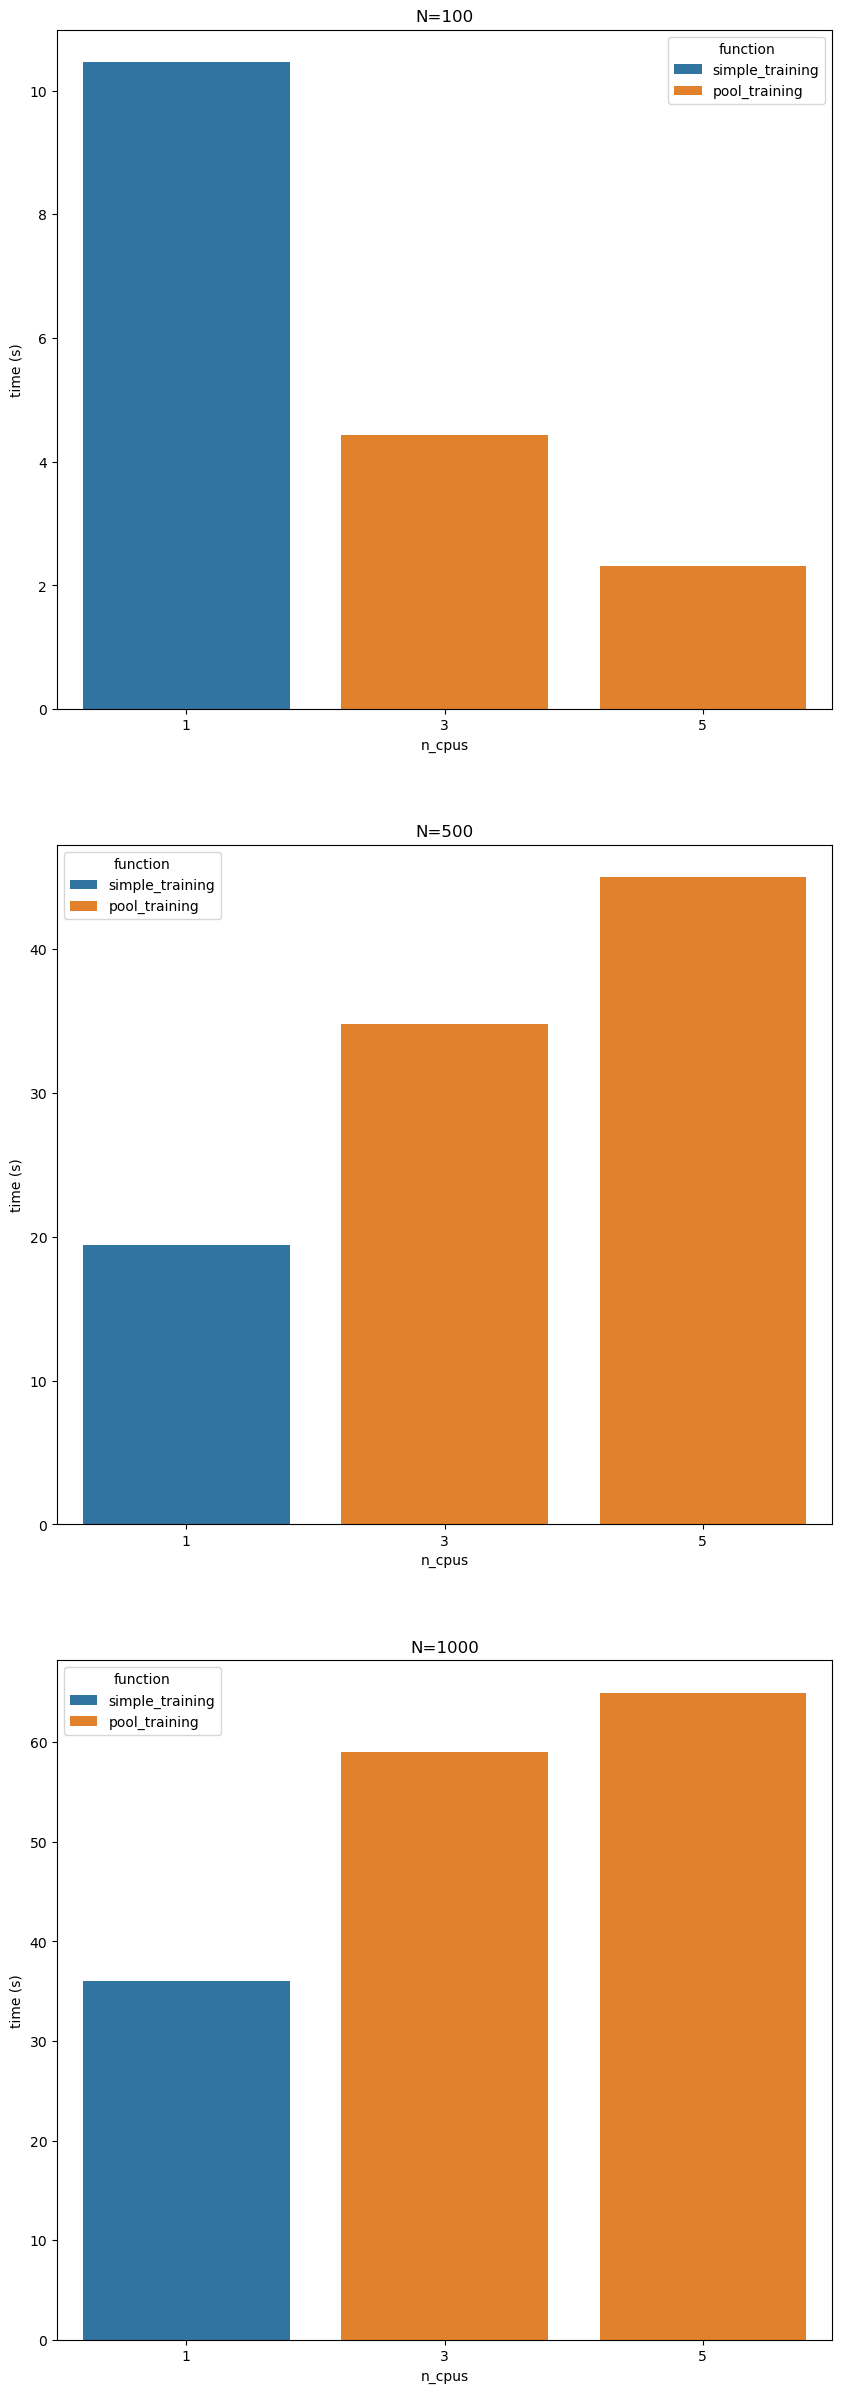

In [13]:
csv = "benchmark_4.csv"


def _training(params_tuple, x_train_3D_scaled, y_train_3D_scaled):
    reservoir_dict, ridge_dict = params_tuple
    model = ModelConfiguration(
        input_kwargs={},
        reservoir_kwargs=reservoir_dict,
        ridge_kwargs=ridge_dict,
        fit_kwargs={},
        input_to_readout=False,
        readout_feedback_to_reservoir=False,
    )
    model.fit(x_train_3D_scaled, y_train_3D_scaled)
    return model.run(x_train_3D_scaled)


def simple_training(params_tuple_list, x_train_3D_scaled, y_train_3D_scaled):
    preds_list = [
        _training(params_tuple, x_train_3D_scaled, y_train_3D_scaled)
        for params_tuple in params_tuple_list
    ]


def pool_training(
    params_tuple_list, x_train_3D_scaled, y_train_3D_scaled, n_cpus: int, chunksize=None
):
    with Pool(n_cpus) as p:
        preds_list = p.starmap(
            _training,
            zip(
                params_tuple_list, repeat(x_train_3D_scaled), repeat(y_train_3D_scaled)
            ),
            chunksize=chunksize,
        )


try:
    df = pd.read_csv(csv)
except:
    df_list = []
    for units in [100, 500, 1000]:
        ####
        params_tuple_list = []
        for seed in range(5):
            reservoir_dict = dict(
                units=units,
                sr=0.1,
                lr=0.1,
                seed=seed,
            )
            ridge_dict = dict(
                ridge=0.1,
            )

            params_tuple_list.append((reservoir_dict, ridge_dict))
        ####
        for n_cpus in [3, 5]:
            t0 = time()
            pool_training(
                params_tuple_list, x_train_3D_scaled, y_train_3D_scaled, n_cpus
            )
            df_list.append(
                {
                    "units": units,
                    "n_cpus": n_cpus,
                    "function": "pool_training",
                    "time (s)": time() - t0,
                }
            )
        ######
        n_cpus = 1

        t0 = time()
        simple_training(params_tuple_list, x_train_3D_scaled, y_train_3D_scaled)
        df_list.append(
            {
                "units": units,
                "n_cpus": n_cpus,
                "function": "simple_training",
                "time (s)": time() - t0,
            }
        )

    df = pd.DataFrame(df_list)
    df.to_csv(csv)


units_list = df["units"].unique()
n_plots = len(units_list)

_, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(10, 10 * n_plots))


for i, units in enumerate(units_list):
    df_plot = df[df["units"] == units]
    sns.barplot(df_plot, x="n_cpus", y="time (s)", hue="function", ax=axs[i])
    axs[i].set_title(f"N={units}")